# Time Series Classification Algorithms - (8) Feature Based

<div style="border: 1px solid #007acc; background-color: #e6f4ff; padding: 10px; border-radius: 5px; color: black;">
  <strong>📘 Info:</strong> I do not claim ownership of the content in this notebook. It is based on official <a href="https://www.aeon-toolkit.org/en/latest/examples.html" target="_blank">aeon tutorials</a>, and parts of the code or text may have been copy-pasted or adapted directly from those or other sources for learning purposes.
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from sklearn import metrics

import time

In [3]:
from aeon.datasets import load_classification
from aeon.utils.discovery import all_estimators

# all_estimators("classifier", tag_filter={"algorithm_type": "feature"})

In [4]:
from aeon.classification.feature_based import (
    Catch22Classifier,
    FreshPRINCEClassifier,
    TSFreshClassifier
)

In [5]:
DATASET_NAMES = [
    "MelbournePedestrian",
    "ArrowHead",
    "Colposcopy"
]

X_train_dict, y_train_dict = {}, {}
X_test_dict, y_test_dict = {}, {}

accuracy_dict, f1_score_dict, duration_dict = {}, {}, {}

for dataset_name in DATASET_NAMES: 
    X_train_dict[dataset_name], y_train_dict[dataset_name] = load_classification(
        dataset_name, split="train"
    )
    X_test_dict[dataset_name], y_test_dict[dataset_name] = load_classification(
        dataset_name, split="test"
    )

    X_train_dict[dataset_name] = X_train_dict[dataset_name].squeeze(1)
    X_test_dict[dataset_name] = X_test_dict[dataset_name].squeeze(1)

    accuracy_dict[dataset_name] = {}
    f1_score_dict[dataset_name] = {}
    duration_dict[dataset_name] = {}

```bibtex
@article{middlehurst2024,
  author={Middlehurst, Matthew and Sch{\"a}fer, Patrick and Bagnall, Anthony},
  title={Bake Off Redux: A Review and Experimental Evaluation of Recent Time Series Classification Algorithms},
  journal={Data Mining and Knowledge Discovery},
  volume={38},
  pages={1958--2031},
  year={2024},
  doi={10.1007/s10618-024-01022-1},
  url={https://doi.org/10.1007/s10618-024-01022-1}
}
```

"Feature based classifiers are a popular recent theme. These extract descriptive statistics as features from time series to be used in classifiers. Typically, these features summarise the whole series, so we characterise these as series-to-vector transforms. Most commonly, these features are used in a simple pipeline of transformation followed by a classifier. Several toolkits exist for extracting features." \cite{middlehurst2024}

<img src="images/08_featurebased.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">


## 1. Catch22

```bibtex
@article{lubba2019,
  author={Christoph H. Lubba and Teemu Sethi and Philipp Knaute and Simon R. Schultz and Ben D. Fulcher and Nick S. Jones},
  title={catch22: Canonical Time-Series Characteristics},
  journal={Data Mining and Knowledge Discovery},
  volume={33},
  number={6},
  pages={1821--1852},
  year={2019},
  publisher={Springer},
  doi={10.1007/s10618-019-00647-x},
  url={https://doi.org/10.1007/s10618-019-00647-x}
}
```

Proposed by \cite{lubba2019}.

"The highly comparative time-series analysis (hctsa) toolbox can create over 7700 features for exploratory time series analysis. The canonical time series characteristics (Catch22) are 22 hctsa features determined to be the most discriminatory of the full set. The Catch22 features were chosen by an evaluation on the UCR datasets. The hctsa features were initially pruned, removing those which are sensitive to the series mean and variance and those that could not be calculated on over 80% of the UCR datasets. A feature evaluation was then performed based on predictive performance. Any features which performed below a threshold were removed. For the remaining features, a hierarchical clustering was performed on the correlation matrix to remove redundancy. From each of the 22 clusters formed, a single feature was selected, taking into account balanced accuracy, computational efﬁciency and interpretability. The Catch22 features cover a wide range of concepts such as basic statistics of time series values, linear correlations, and entropy. Reported results for Catch22 are based on training a decision tree classiﬁer after applying the transform to each time series, the implementation we use builds a Random Forest classiﬁer." \cite{middlehurst2024}

In [6]:
method = "Catch22"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    c22 = Catch22Classifier()
    c22.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    c22_preds = c22.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], c22_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], c22_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

Catch22
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.93
F1-Score: 0.93
Duration: 1.45 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.76
F1-Score: 0.76
Duration: 0.56 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.39
F1-Score: 0.34
Duration: 0.28 seconds


## 2. Time Series Feature Extraction based on Scalable Hypothesis Tests (TSFresh)

```bibtex
@article{christ2018,
  author={Maximilian Christ and Nils Braun and Julius Neuffer and Andreas W. Kempa-Liehr},
  title={Time Series Feature Extraction on Basis of Scalable Hypothesis Tests (tsfresh -- A Python Package)},
  journal={Neurocomputing},
  volume={307},
  pages={72--77},
  year={2018},
  publisher={Elsevier},
}
```

Proposed by \cite{christ2018}.

"TSFresh is a collection of just under 800 features extracted from time series. While the features can be used on their own, a feature selection method called FRESH is provided to remove irrelevant features. FRESH considered each feature using multiple hypotheses tests, including Fisher’s exact test, the Kolmogorov-Smirnov test and the Kendal rank test. The Benjamini-Yekutieli procedure is then
used to control the false discovery rate caused by comparing multiple hypotheses and features simultaneously. Results for the base features and after using the FRESH algorithm are reported using both a Random Forest and AdaBoost classifier." \cite{middlehurst2024}

In [7]:
method = "TSFresh"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    ts_fresh = TSFreshClassifier()
    ts_fresh.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    ts_fresh_preds = ts_fresh.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], ts_fresh_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], ts_fresh_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

TSFresh
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.96
F1-Score: 0.96
Duration: 234.84 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.71
F1-Score: 0.71
Duration: 19.81 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.39
F1-Score: 0.33
Duration: 15.37 seconds


## 3. Fresh Pipeline with RotatIoN forest (Fresh PRINCE)

```bibtex
@inproceedings{middlehurst2022,
  author={Matthew Middlehurst and Anthony Bagnall},
  title={The FreshPRINCE: A Simple Transformation-Based Pipeline Time Series Classifier},
  booktitle={Proceedings of the International Conference on Pattern Recognition and Artificial Intelligence},
  pages={150--161},
  year={2022},
  publisher={Springer}
}
```

Proposed by \cite{middlehurst2022}.

"A comparison of alternative pipelines of feature extractor and classifier found that the most effective approach was the full set of TSFresh features with no feature selection applied, and combined with a Rotation Forest classifier. This pipeline was called the FreshPRINCE." \cite{middlehurst2024}

In [8]:
method = "FreshPRINCE"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    fresh_prince = FreshPRINCEClassifier()
    fresh_prince.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    fresh_prince_preds = fresh_prince.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], fresh_prince_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], fresh_prince_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

FreshPRINCE
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.97
F1-Score: 0.97
Duration: 261.81 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.63
F1-Score: 0.64
Duration: 52.02 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.47
F1-Score: 0.38
Duration: 49.13 seconds


## 4. Comparison between the Classifiers

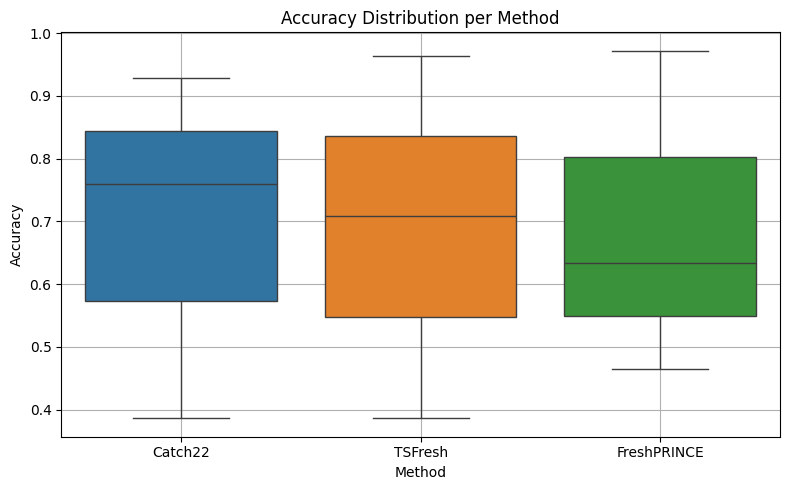

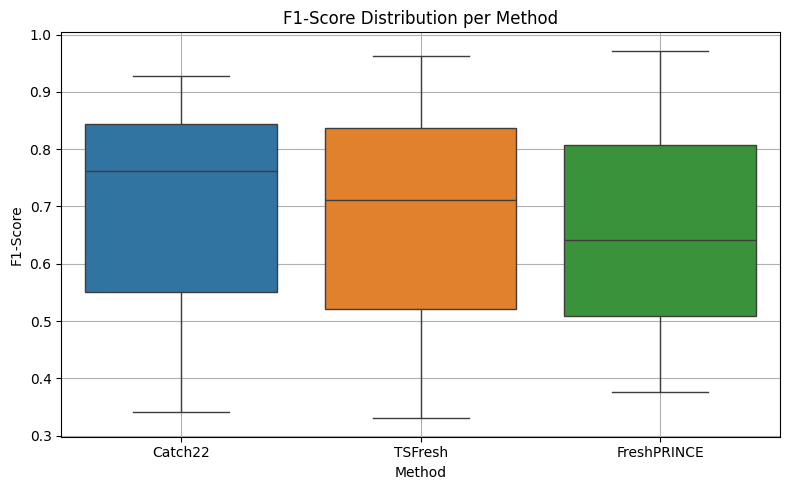

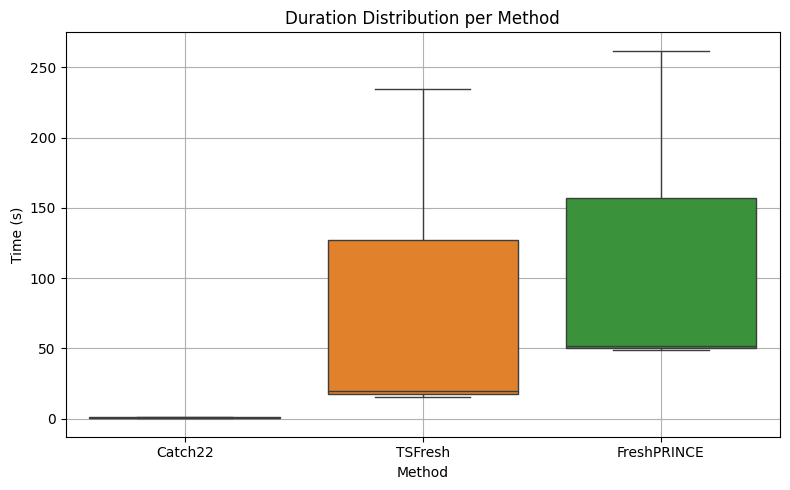

In [9]:
datasets = list(accuracy_dict.keys())
methods = list(next(iter(accuracy_dict.values())).keys())

def prepare_long_format(metric_dict, metric_name):
    records = []
    for ds in datasets:
        for method in methods:
            val = metric_dict[ds][method]
            if isinstance(val, (int, float)):
                records.append({
                    "Dataset": ds,
                    "Method": method,
                    "Metric": float(val),
                    "Type": metric_name
                })
    return pd.DataFrame(records)

df_accuracy = prepare_long_format(accuracy_dict, "Accuracy")
df_f1 = prepare_long_format(f1_score_dict, "F1-Score")
df_duration = prepare_long_format(duration_dict, "Duration (s)")

df_all = pd.concat([df_accuracy, df_f1, df_duration], ignore_index=True)

def plot_boxplot(df, title, ylabel):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="Method", y="Metric", hue="Method")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Method")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_boxplot(df_accuracy, "Accuracy Distribution per Method", "Accuracy")
plot_boxplot(df_f1, "F1-Score Distribution per Method", "F1-Score")
plot_boxplot(df_duration, "Duration Distribution per Method", "Time (s)")